# Exploration of Transfer Learning

In [4]:
# %pip install torchsummary

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# %pip install torchsummary

from torchsummary import summary

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Train, Eval and Helper Functions
---

In [7]:
NUM_EPOCHS = 30

def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=30, device='cpu'):
    
    # Move model to device
    model = model.to(device)
    
    # For tracking metrics
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):

        #Training Phase
        model.train()
        # print(f"Epoch {epoch} in progress...")
        running_loss = 0

        for batch_idx, (X, y) in enumerate(train_loader):
            
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Evaluation Phase
        model.eval()

        test_loss = 0
        correct = 0
        with torch.no_grad():

            for (X,y) in test_loader:
                X, y = X.to(device), y.to(device)
                output = model.forward(X)
                test_loss += criterion(output, y).item()

                # Get the index of the max log-probability
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(y.view_as(pred)).sum().item()
                

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)
        
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%\n')
    
    return train_losses, test_losses, test_accuracies


In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_pred = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            pred = output.argmax(dim=1)

            all_pred.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
    return all_pred, all_targets

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [10]:
def plot_train_metrics(train_losses, test_losses, test_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_eval_res(predictions, targets):
    
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(targets, predictions))    


## CIFAR10 Dataset
---
Useful for more complex NN architecture testing purposes.

In [12]:
# import ssl
# import urllib.request

# # Disable SSL certificate verification
# ssl._create_default_https_context = ssl._create_unverified_context

In [17]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=False, num_workers=2)

# Class names for reference
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
class Pre_Trained_Model(nn.Module):
    def __init__(self):
        super(Pre_Trained_Model, self).__init__()
        model = torchvision.models.resnet18(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)
        self.model = model

        # for params in model.parameters():
        #     params.requires_grad = False

    def forward(self, x):
        return self.model(x)
    
model_1 = Pre_Trained_Model()
model_1.to(device)


c:\Users\pcadmin\anaconda3\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pcadmin\anaconda3\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pre_Trained_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [21]:
summary(model_1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Epoch: 1/30
Train Loss: 1.0136
Test Loss: 0.7321
Test Accuracy: 75.43%

Epoch: 2/30
Train Loss: 0.6709
Test Loss: 0.6687
Test Accuracy: 77.56%

Epoch: 3/30
Train Loss: 0.5827
Test Loss: 0.6411
Test Accuracy: 78.87%

Epoch: 4/30
Train Loss: 0.5246
Test Loss: 0.5702
Test Accuracy: 81.09%

Epoch: 5/30
Train Loss: 0.4825
Test Loss: 0.5592
Test Accuracy: 81.40%

Epoch: 6/30
Train Loss: 0.4561
Test Loss: 0.5497
Test Accuracy: 81.51%

Epoch: 7/30
Train Loss: 0.4262
Test Loss: 0.5066
Test Accuracy: 82.76%

Epoch: 8/30
Train Loss: 0.4019
Test Loss: 0.5483
Test Accuracy: 82.18%

Epoch: 9/30
Train Loss: 0.3810
Test Loss: 0.5358
Test Accuracy: 82.41%

Epoch: 10/30
Train Loss: 0.3639
Test Loss: 0.4972
Test Accuracy: 84.04%

Epoch: 11/30
Train Loss: 0.3406
Test Loss: 0.5096
Test Accuracy: 83.55%

Epoch: 12/30
Train Loss: 0.3346
Test Loss: 0.5004
Test Accuracy: 84.46%

Epoch: 13/30
Train Loss: 0.3192
Test Loss: 0.5185
Test Accuracy: 83.44%

Epoch: 14/30
Train Loss: 0.3062
Test Loss: 0.4672
Test Accur

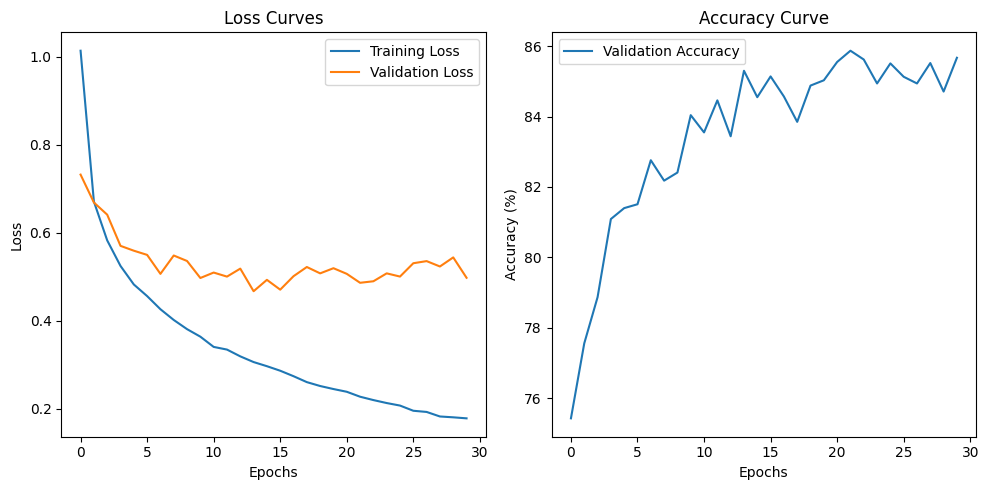

In [22]:
# Not freezing the parameters, takes very long to train
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

train_losses_1, test_losses_1, test_accuracies_1 = train_model(model_1, optimizer_1, criterion_1, trainloader, testloader, num_epochs=30, device=device)

plot_train_metrics(train_losses_1, test_losses_1, test_accuracies_1)


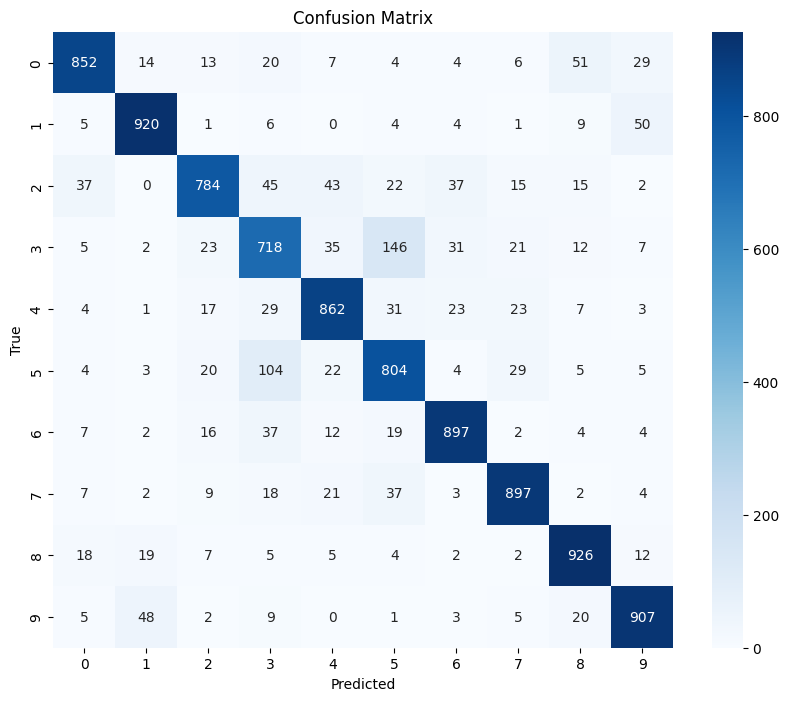

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1000
           1       0.91      0.92      0.91      1000
           2       0.88      0.78      0.83      1000
           3       0.72      0.72      0.72      1000
           4       0.86      0.86      0.86      1000
           5       0.75      0.80      0.78      1000
           6       0.89      0.90      0.89      1000
           7       0.90      0.90      0.90      1000
           8       0.88      0.93      0.90      1000
           9       0.89      0.91      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [23]:
pred, targets = evaluate_model(model_1, testloader, device)
plot_eval_res(pred, targets)

## ResNet Transfer Learning by freezing Conv layers
---

In [24]:
class Transfer_Learning(nn.Module):
    def __init__(self, num_classes=10):
        super(Transfer_Learning, self).__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        for param in self.base_model.parameters():
            param.requires_grad = False

        #Unfreeze the last convolutional block (layer4)
        for param in self.base_model.layer4.parameters():
            param.requires_grad = True

    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

model_2 = Transfer_Learning()
model_2.to(device)

c:\Users\pcadmin\anaconda3\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pcadmin\anaconda3\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Transfer_Learning(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [25]:
summary(model_2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Epoch: 1/100
Train Loss: 1.3846
Test Loss: 1.0948
Test Accuracy: 61.83%

Epoch: 2/100
Train Loss: 1.0684
Test Loss: 1.0069
Test Accuracy: 64.92%

Epoch: 3/100
Train Loss: 0.9977
Test Loss: 0.9405
Test Accuracy: 67.84%

Epoch: 4/100
Train Loss: 0.9463
Test Loss: 0.9247
Test Accuracy: 68.16%

Epoch: 5/100
Train Loss: 0.9134
Test Loss: 0.9160
Test Accuracy: 68.57%

Epoch: 6/100
Train Loss: 0.8794
Test Loss: 0.8963
Test Accuracy: 68.77%

Epoch: 7/100
Train Loss: 0.8502
Test Loss: 0.9000
Test Accuracy: 69.25%

Epoch: 8/100
Train Loss: 0.8336
Test Loss: 0.8834
Test Accuracy: 69.59%

Epoch: 9/100
Train Loss: 0.8065
Test Loss: 0.9033
Test Accuracy: 68.83%

Epoch: 10/100
Train Loss: 0.7899
Test Loss: 0.9022
Test Accuracy: 69.09%

Epoch: 11/100
Train Loss: 0.7761
Test Loss: 0.8735
Test Accuracy: 70.51%

Epoch: 12/100
Train Loss: 0.7550
Test Loss: 0.8718
Test Accuracy: 70.02%

Epoch: 13/100
Train Loss: 0.7431
Test Loss: 0.8998
Test Accuracy: 69.60%

Epoch: 14/100
Train Loss: 0.7268
Test Loss: 0.8

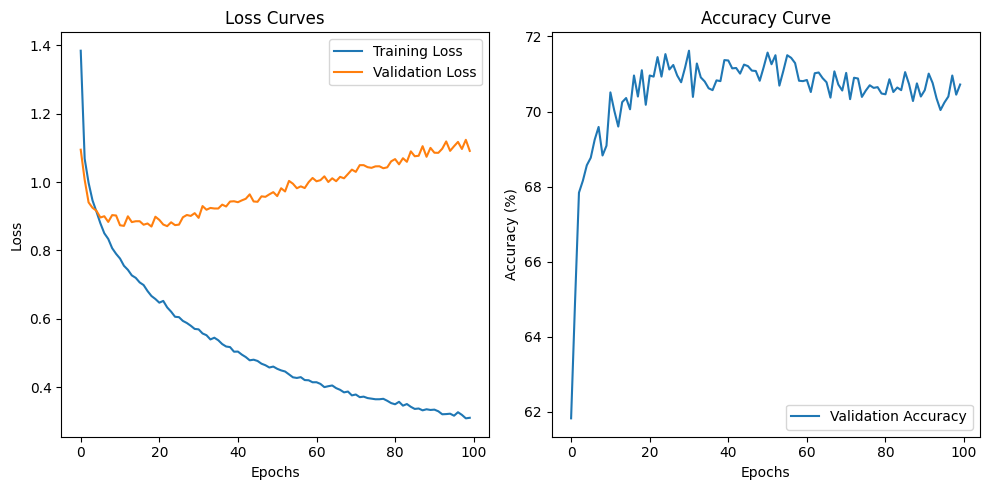

In [26]:
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

train_losses_2, test_losses_2, test_accuracies_2 = train_model(model_2, optimizer_2, criterion_2, trainloader, testloader, num_epochs=100, device=device)

plot_train_metrics(train_losses_2, test_losses_2, test_accuracies_2)

Overfitting can be observed after epocs 15-30, where validation loss is constant while train loss reduces. Eventually, validation loss increases while train loss decreases. Classic overfitting, network is not complex enough in comparision to the task at hand.

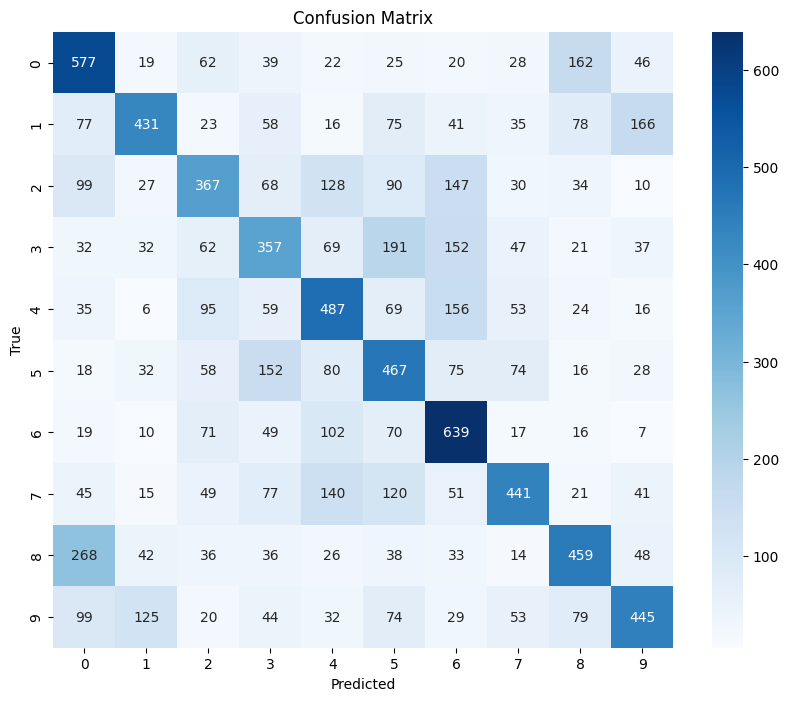

              precision    recall  f1-score   support

           0       0.45      0.58      0.51      1000
           1       0.58      0.43      0.50      1000
           2       0.44      0.37      0.40      1000
           3       0.38      0.36      0.37      1000
           4       0.44      0.49      0.46      1000
           5       0.38      0.47      0.42      1000
           6       0.48      0.64      0.55      1000
           7       0.56      0.44      0.49      1000
           8       0.50      0.46      0.48      1000
           9       0.53      0.45      0.48      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



In [19]:
pred, targets = evaluate_model(model_2, testloader, device)
plot_eval_res(pred, targets)